In [13]:
import sys

import torch

sys.path.append("../")
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from lib.datasets import HomogeneousPipelineDataset
from lib.models import HomogeneousGCN
from lib.pl import LightningModule

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
model = LightningModule.load_from_checkpoint(r"C:\Users\Konstantin\PycharmProjects\NIR\experiments\default_homogeneous_gcn_undirected_data\version_0\checkpoints\epoch=57-step=232.ckpt",
    model=HomogeneousGCN(in_channels=60, out_channels=2),
    loss=F.mse_loss, )
model = model.eval()

In [16]:
dataset = HomogeneousPipelineDataset(
    r"C:\Users\Konstantin\PycharmProjects\NIR\dataset\pipeline_dataset",
    direction="undirected",
)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [17]:
preds = []
gt = []
for batch in iter(loader):
    x, y = batch
    with torch.no_grad():
        pred = model.model(x).numpy()
    pred_scaled_back = dataset._metrics_scaler.inverse_transform(pred)
    gt_scaled_back = dataset._metrics_scaler.inverse_transform(y)
    gt.append(gt_scaled_back)
    preds.append(pred_scaled_back)

In [18]:
pred_f1, pred_roc_auc = np.vstack(preds).T
f1, roc_auc = np.vstack(gt).T

In [19]:
mean_f1 = np.mean(f1)
mean_roc_auc = np.mean(roc_auc)
print("Mean f1: ", mean_f1)
print("Mean roc_auc: ", mean_roc_auc)

Mean f1:  0.9189877079999373
Mean roc_auc:  0.7434530293208174


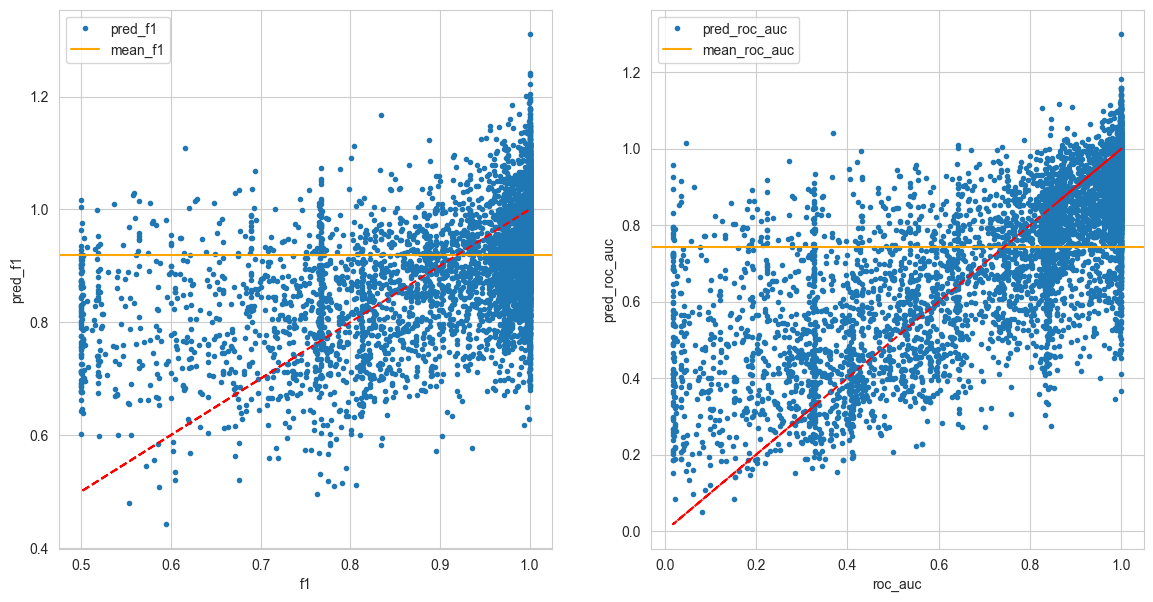

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(f1, pred_f1, ls="", marker=".", label="pred_f1")
ax[0].axhline(y=mean_f1, c="orange", label="mean_f1")
ax[0].plot(f1, f1, ls="--", c="red")
ax[0].set_xlabel("f1")
ax[0].set_ylabel("pred_f1")
ax[0].legend()
ax[1].plot(roc_auc, pred_roc_auc, ls="", marker=".", label="pred_roc_auc")
ax[1].axhline(y=mean_roc_auc, c="orange", label="mean_roc_auc")
ax[1].plot(roc_auc, roc_auc, ls="--", c="red")
ax[1].set_xlabel("roc_auc")
ax[1].set_ylabel("pred_roc_auc")
ax[1].legend()
plt.show()

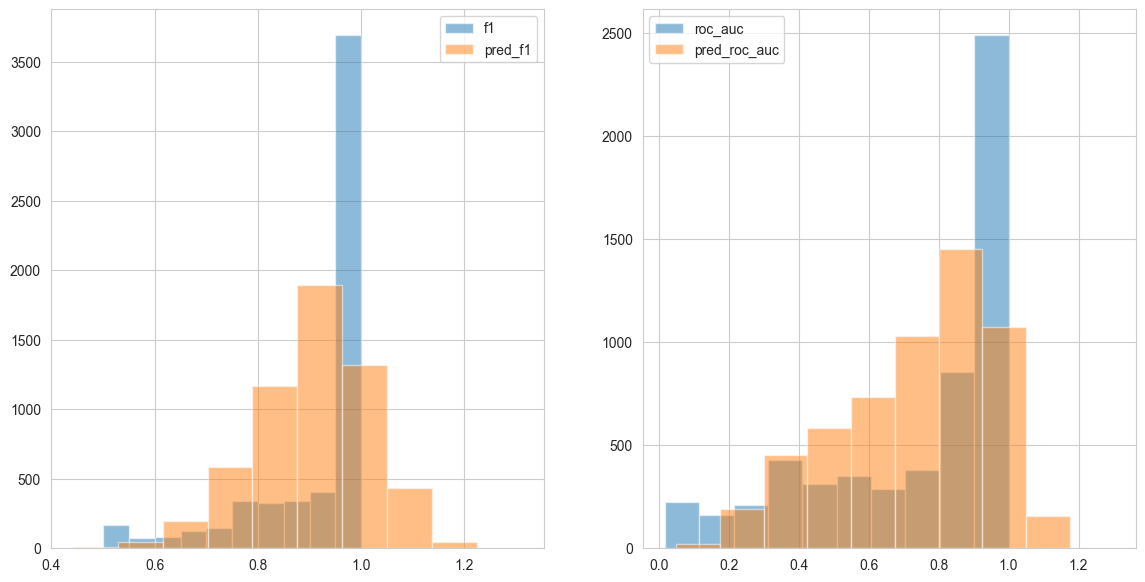

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].hist(f1, label="f1", alpha=0.5)
ax[0].hist(pred_f1, label="pred_f1", alpha=0.5)
ax[0].legend()
ax[1].hist(roc_auc, label="roc_auc", alpha=0.5)
ax[1].hist(pred_roc_auc, label="pred_roc_auc", alpha=0.5)
ax[1].legend()
plt.show()

In [22]:
print(F.mse_loss(torch.tensor(f1).reshape(-1, 1), torch.tensor(pred_f1).reshape(-1, 1)))
print(F.mse_loss(torch.tensor(f1).reshape(-1, 1), torch.tensor([mean_f1] * len(f1)).reshape(-1, 1)))

tensor(0.0141, dtype=torch.float64)
tensor(0.0155, dtype=torch.float64)


In [23]:
print(F.mse_loss(torch.tensor(roc_auc).reshape(-1, 1), torch.tensor(pred_roc_auc).reshape(-1, 1)))
print(F.mse_loss(torch.tensor(roc_auc).reshape(-1, 1), torch.tensor([mean_roc_auc] * len(f1)).reshape(-1, 1)))

tensor(0.0386, dtype=torch.float64)
tensor(0.0832, dtype=torch.float64)


In [26]:
# Joined loss
print(F.mse_loss(torch.tensor(np.vstack([f1, roc_auc])).reshape(-1, 1), torch.tensor(np.vstack([pred_f1, pred_roc_auc])).reshape(-1, 1)))
print(F.mse_loss(torch.tensor(np.vstack([f1, roc_auc])).reshape(-1, 1), torch.tensor([mean_f1, mean_roc_auc] * len(f1)).reshape(-1, 1)))


tensor(0.0263, dtype=torch.float64)
tensor(0.0651, dtype=torch.float64)
